# Evaluate the Robustness of the Model against Adversarial Examples

### Import Statements

In [ ]:
from tensorflow.keras import optimizers # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pickle
from keras.utils import to_categorical # type: ignore
from copy import deepcopy
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from utils import *
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore

### Deep Fool Algorithm

In [ ]:
def compute_perturbation(model, x1, label_x0, label_k, val_grad):
    # Get gradient and function value for class k
    gradient_k, fx1 = grad_val(model, x1, label_k)
    
    # Calculate the difference between gradients
    gradient_diff = [g - g0 for g, g0 in zip(gradient_k, val_grad)]
    gradient_diff_norm = np.sqrt(np.sum([np.linalg.norm(g)**2 for g in gradient_diff]))
    
    # Compute the function value difference for class k
    f_k = fx1[0, label_k] - fx1[0, label_x0]
    
    # Compute the weighted gradient ratio
    fk_wk = np.linalg.norm(f_k) / (gradient_diff_norm + 1e-3)
    
    return gradient_diff, fk_wk, f_k

def deep_fool_algorithm(model, x0, step=0.01, max_iter=15):
    # Get the initial prediction and label of x0
    preds = model(x0)[0]
    initial_label = np.argmax(preds)
    x1 = deepcopy(x0)
    current_label = initial_label
    loop_iter = 0
    perturbations = []

    while current_label == initial_label and loop_iter < max_iter:
        perturb_direction = [np.zeros_like(x_input) for x_input in x0]
        perturb_magnitude = 0
        best_l = np.inf
        
        # Get the gradient and function value for the initial label
        val_grad, fx1 = grad_val(model, x1, initial_label)
        
        # Iterate over all classes except the true label
        for label_k in range(10):
            if label_k == initial_label:
                continue

            # Compute perturbation for the current class label
            perturb_diff, fk_wk, f_k = compute_perturbation(model, x1, initial_label, label_k, val_grad)
            
            # Update perturbation if the current perturbation direction is better
            if fk_wk < best_l:
                perturb_direction, perturb_magnitude = perturb_diff, f_k
                best_l = fk_wk
        
        # Normalize the perturbation
        perturb_direction_norm_squared = np.sum([np.linalg.norm(w_l_input)**2 for w_l_input in perturb_direction])
        perturb_magnitude_norm = np.linalg.norm(perturb_magnitude)
        perturb_constant = perturb_magnitude_norm / (perturb_direction_norm_squared + 1e-3)
        
        # Scale the perturbation by the calculated constant
        perturbation = [perturb_constant * w_l_input for w_l_input in perturb_direction]
        perturbations.append(perturbation)

        # Update x1 with the new perturbation
        x1 = [x1_item + (1 + step) * perturb_item for x1_item, perturb_item in zip(x1, perturbation)]
        x1 = np.array(x1)

        # Get the new prediction for x1
        preds = model(x1)[0]
        current_label = np.argmax(preds)
        loop_iter += 1

    # Sum up all perturbations for the final result
    total_perturbation = [np.zeros_like(x_input) for x_input in x0]
    for i in range(len(x0)):
        for perturb in perturbations:
            total_perturbation[i] += perturb[i][0]

    return total_perturbation, loop_iter, current_label


### CNN - Results

In [ ]:
sr = 22050 #librosa predefined sampling rate
hop = round(sr * 0.0125)
time = 4*sr//hop+1

for f in range(1, 10+1):

    robustness_values_cnn_fold = []
    X_folds = []
    y_folds = []


    le = LabelEncoder()

    for i in range(10):
        X_fold = np.load(f'fold_{i + 1}_40mfcc_features.npy', allow_pickle=True)
        y_fold = np.load(f'fold_{i + 1}_40mfcc_labels.npy', allow_pickle=True)

        scalers = {}
        scalers_aug = {}
        for i in range(X_fold.shape[1]):
            scalers[i] = StandardScaler()
            X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
        y_fold = to_categorical(le.fit_transform(y_fold))

        X_folds.append(X_fold)
        y_folds.append(y_fold)

    print(f"Fold {f} loaded")
    fold_model_cnn = keras.models.load_model(f"model_fold{f-1}.keras", compile=False)
    fold_model_cnn.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    for i in range(len(X_fold)):
        print(f"Fold {f} - Example {i+1}")
        example_input = X_fold[i]
        example_input = example_input.reshape(example_input.shape[0], example_input.shape[1],1) 
        example_input = np.expand_dims(example_input, axis=0)
        perturbation, iters, fool_label = deep_fool_algorithm(fold_model_cnn, example_input)
        robustness_values_cnn_fold.append(robustness_val(example_input, perturbation))

    save_pkl(robustness_values_cnn_fold, f"deepfool_fold{f}.pkl")

Fold 1 loaded
Fold 1 - Example 1
Fold 1 - Example 2
Fold 1 - Example 3
Fold 1 - Example 4
Fold 1 - Example 5
Fold 1 - Example 6
Fold 1 - Example 7
Fold 1 - Example 8
Fold 1 - Example 9
Fold 1 - Example 10
Fold 1 - Example 11
Fold 1 - Example 12
Fold 1 - Example 13
Fold 1 - Example 14
Fold 1 - Example 15
Fold 1 - Example 16
Fold 1 - Example 17
Fold 1 - Example 18
Fold 1 - Example 19
Fold 1 - Example 20
Fold 1 - Example 21
Fold 1 - Example 22
Fold 1 - Example 23
Fold 1 - Example 24
Fold 1 - Example 25
Fold 1 - Example 26
Fold 1 - Example 27
Fold 1 - Example 28
Fold 1 - Example 29
Fold 1 - Example 30
Fold 1 - Example 31
Fold 1 - Example 32
Fold 1 - Example 33
Fold 1 - Example 34
Fold 1 - Example 35
Fold 1 - Example 36
Fold 1 - Example 37
Fold 1 - Example 38
Fold 1 - Example 39
Fold 1 - Example 40
Fold 1 - Example 41
Fold 1 - Example 42
Fold 1 - Example 43
Fold 1 - Example 44
Fold 1 - Example 45
Fold 1 - Example 46
Fold 1 - Example 47
Fold 1 - Example 48
Fold 1 - Example 49
Fold 1 - Exampl

### Robustness Results

In [8]:
for f in range(0, 10):
    robustness_values_cnn_fold = load_pkl(f"deepfool_fold{f+1}.pkl")
    mean_value, std_value = np.mean(np.array(robustness_values_cnn_fold)), np.std(np.array(robustness_values_cnn_fold))
    print(f"Robustness Value for Fold {f+1}: {mean_value: .3f} +/-{std_value: .3f}.")

Robustness Value for Fold 1:  0.025 +/- 0.027.
Robustness Value for Fold 2:  0.043 +/- 0.058.
Robustness Value for Fold 3:  0.040 +/- 0.071.
Robustness Value for Fold 4:  0.031 +/- 0.037.
Robustness Value for Fold 5:  0.029 +/- 0.032.
Robustness Value for Fold 6:  0.027 +/- 0.031.
Robustness Value for Fold 7:  0.042 +/- 0.050.
Robustness Value for Fold 8:  0.051 +/- 0.074.
Robustness Value for Fold 9:  0.036 +/- 0.041.
Robustness Value for Fold 10:  0.027 +/- 0.030.


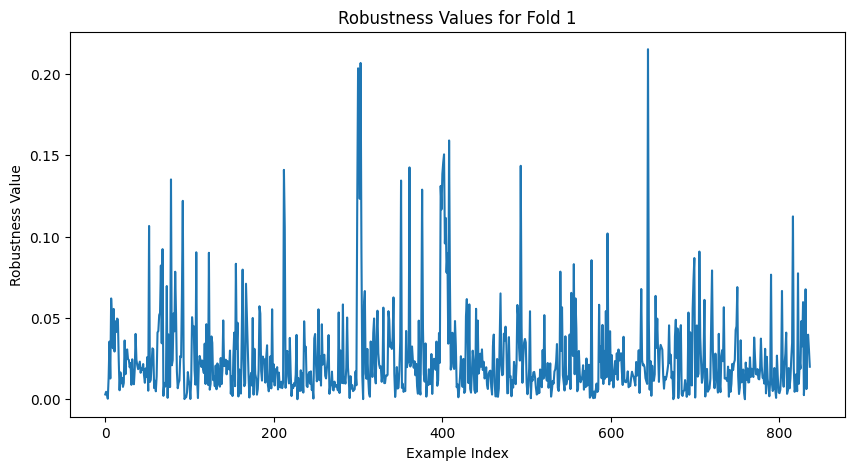

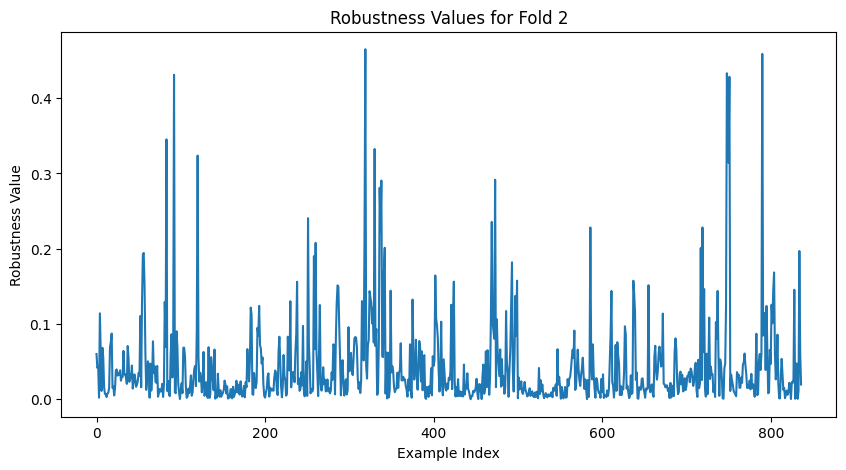

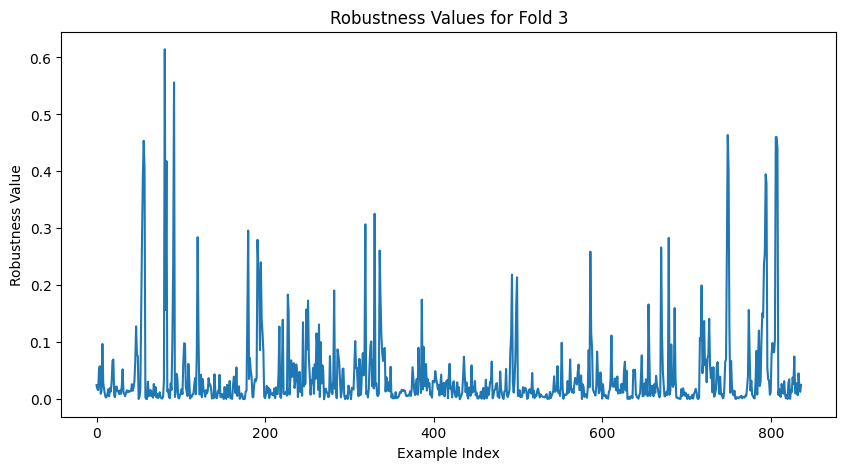

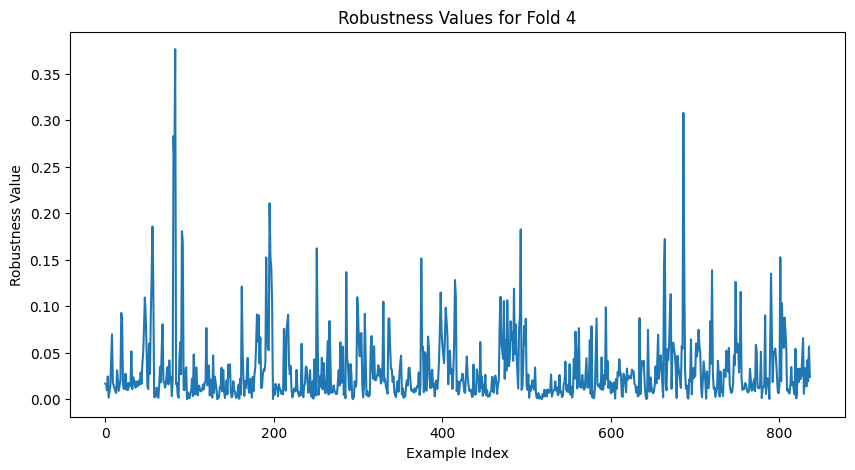

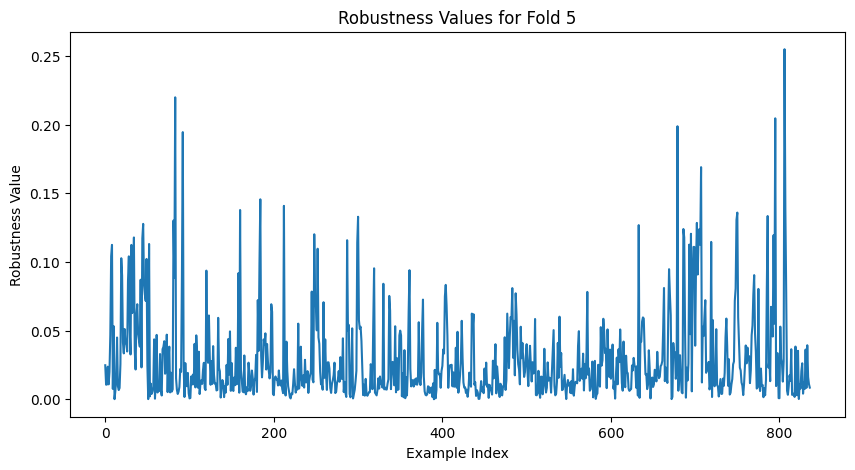

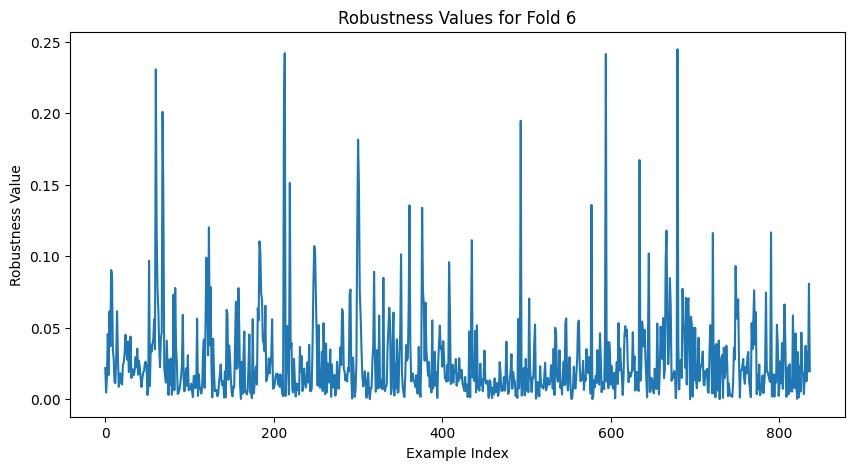

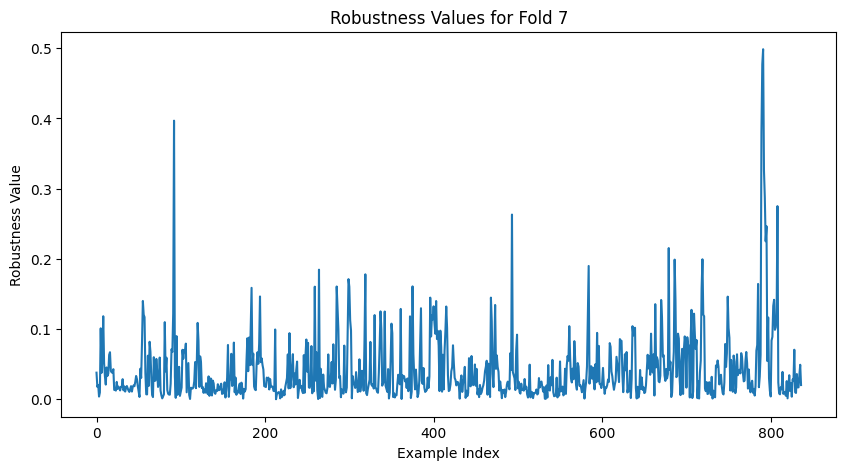

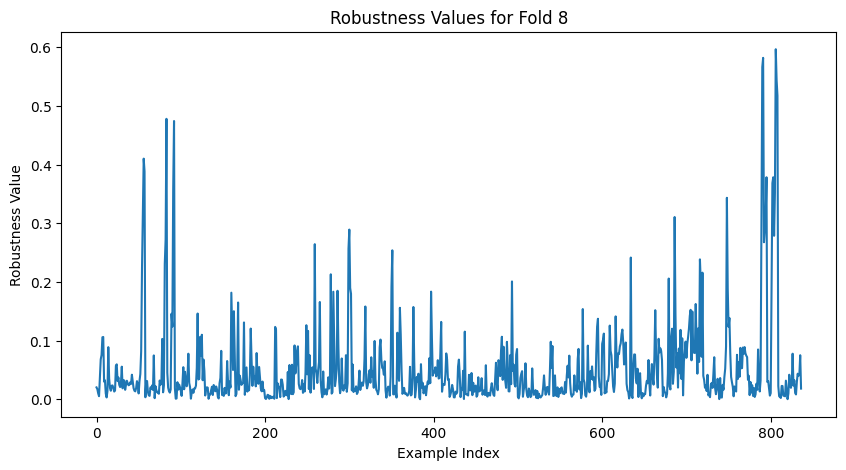

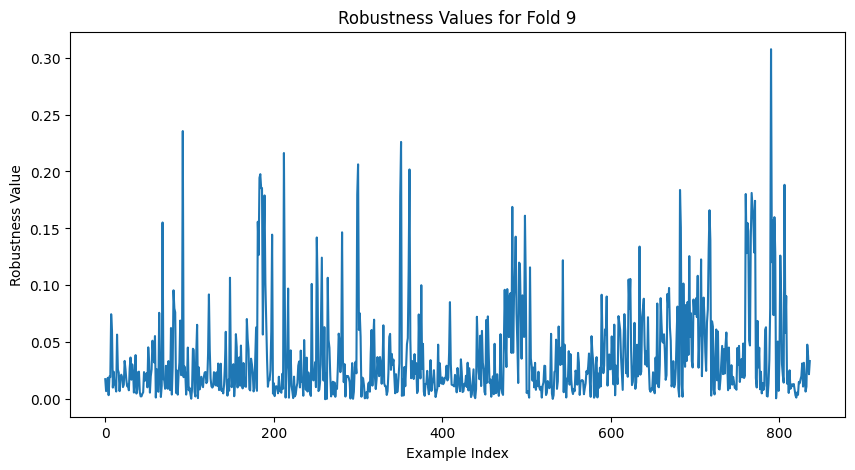

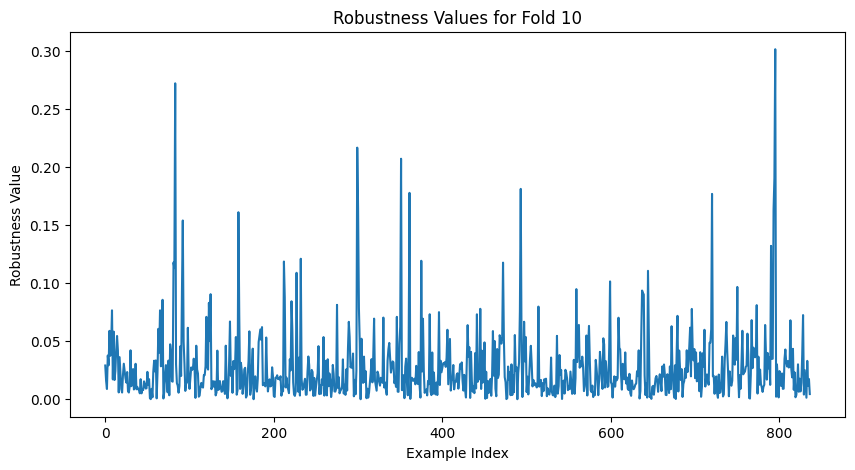

In [ ]:
for f in range(1, 11):
    robustness_values_cnn_fold = load_pkl(f"deepfool_fold{f}.pkl")
    plt.figure(figsize=(10, 5))
    plt.plot(robustness_values_cnn_fold)
    plt.title(f'Robustness Values for Fold {f}')
    plt.xlabel('Example Index')
    plt.ylabel('Robustness Value')
    plt.show()